In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy import linalg
from scipy.optimize import root

import sys
sys.path.insert(0, 'code')

from robot_data import Load_Lidar_Scans as load_scans
from robot_data import Lidar_Scan
from robot_data import robot_trajectory
from datafilters import filters
import coordinate_transforms as cord_trans
import visualizer
import ICP

# All the variables that have been created to retrieve the data:

In [2]:
scans_OBJ = load_scans()
scans_OBJ.load_ranges('data\\LidarScans_ranges.txt')
scans_OBJ.load_angles('data\\LidarScans_angles.txt')

trajectory_OBJ = robot_trajectory()
trajectory_OBJ.load_trajectory('data\\Trajectory.txt')

print('Trajectory: ',trajectory_OBJ.trajectory.shape)
print('traj_len: ',trajectory_OBJ.trajectory_length)
print('traj_dim: ',trajectory_OBJ.trajectory_dimension,'\n')

print('LidarScans: ',scans_OBJ.LidarScan_ranges.shape)
print('num_of_lidarscans: ',scans_OBJ.num_of_LidarScans)
print('LidarScans_angles: ',scans_OBJ.LidarScan_angles.shape)

Trajectory:  (52, 3)
traj_len:  52
traj_dim:  2 

LidarScans:  (51, 240)
num_of_lidarscans:  240
LidarScans_angles:  (240,)


# So at this point I have the odometry measurements, all lidar scans as well as the angles corresponding to those scans

In [3]:
#envir_axes = [[np.amin(Trajectory[:,0])-8,np.amax(Trajectory[:,0])+8],[np.amin(Trajectory[:,1])-8,np.amax(Trajectory[:,1])+8]]
#fig = plt.figure(1, figsize=(5.5,5.5));
#plt.xlim(envir_axes[0]);
#plt.ylim(envir_axes[1]);

# This is a note for the code. This can be added to the report

More precisely, given two point clouds, R (the reference) and S (the source), ICP tries to find the best rigid (or similarity) transform T so that T * S = R.

# The following variables are used for the pose-graph SLAM algorithm

In [4]:
neighbors_to_match_to = 3
# The number of points that read is matched to in the reference

match_threshold_distance = 1
# The maximum distance that a point in the read may be from a 
# point in the reference 

match_threshold_angle = np.pi/3
# The maximum angle between a line through a point in the 
# read may have from a line through a point in the reference

maximum_iterations = 80
# Maximum number of iterations that the ICP algorithm may be run

maximum_transform_limits = [0.8,15]
# maximum rotation and displacement limits between pose's

final_error_limit = 70
# maximum loop closure limit 

ICP_success = [0.001,0.01]
# conditions for success between successive ICP iterations

overlap_threshold = 0.75
# The amount of overlap that a read must have with the reference

robot_state = 0
# Indicates whether the robot is exploring or revisiting

keyframes = []
# Scans used to create the pose graph

local_map = []
# The sequence of keframes that the robot uses to create a map with 
# which it it comapres new scans to.

local_map_size = 3
# This is the number of keyframes that the robot uses to create the 
# local map, which it uses during exploration

no_loop_window = 10
# The number of previous and sequentail keyframes that may not be considered
# for the loop closure process

max_distance_to_loop_closing = 15
max_error_for_loop_closing = 5000

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [5]:
def linear_least_squares_SVD(reference_weighted,read,normals):#,transform):
    
    #x = np.transpose(transform)
    
    A = np.zeros([3])
    for point_read,norm in zip(read,normals):
        row = np.array([[point_read[1]*norm[0] - point_read[1]*norm[1],norm[0],norm[1]]])
        A = np.vstack((A,row))
    A = np.delete(A,0,0)
        
    b = np.zeros(1)
    for point_read,point_ref,norm in zip(read,reference_weighted,normals):
        row = np.array([norm[0]*point_ref[0] + norm[1]*point_ref[1] - norm[0]*point_read[0] - norm[1]*point_read[1]])
        b = np.hstack((b,row))
    b = np.delete(b,0,0)
    b = np.vstack(b)
    
    #U, s, Vh = linalg.svd(A, full_matrices=False)
    #S = np.diag(s)
    
    A_plus = linalg.pinv(A)
    
    return np.matmul(A_plus,b)

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [6]:
def surface_normals(S,number_of_neighbors):

    nbrs = NearestNeighbors(n_neighbors=number_of_neighbors, algorithm='kd_tree').fit(S)
    distances, indices = nbrs.kneighbors(S)

    pca = PCA()
    normals_S = np.zeros(2)
    principle_axes = np.zeros(4)
    surface_region = np.zeros([1,S.shape[1]])

    for i in range(indices.shape[0]):

        for j in indices[i]:
            surface_region = np.vstack((surface_region,S[j]))

        surface_region = np.delete(surface_region,0,0)

        pca_region = pca.fit(surface_region)

        principle_axes = np.append(principle_axes,pca_region.components_)
        normals_S = np.vstack((normals_S,pca_region.components_[1]))
    
    principle_axes = np.reshape(principle_axes,(-1,2,2))
    #normals_S = np.reshape(normals_S,(-1,2))
    
    return [np.delete(normals_S,0,0),np.delete(principle_axes,0,0),distances]

In [7]:
def outlier_rejection(distances_read_refnorm,angles_read_refnorm):
    rejection_weights_per_point = []
    rejection_weights = np.zeros([distances_read_refnorm.shape[0],distances_read_refnorm.shape[0]])
    #for angles_to_multi_plane,distances_to_multi_plane in zip(angles_read_refnorm,distances_read_refnorm):
    #for angle_to_plane,distance_to_plane in zip(angles_to_multi_plane,distances_to_multi_plane):
    for angle_to_plane,distance_to_plane in zip(angles_read_refnorm,distances_read_refnorm):
        if(distance_to_plane > 1 and angle_to_plane > match_threshold_angle):
            rejection_weights_per_point = np.hstack((rejection_weights_per_point,0))
        else:
            rejection_weights_per_point = np.hstack((rejection_weights_per_point,1))
    #for j,weight in enumerate(rejection_weights_per_point):
        #rejection_weights[j,-1,i] = weight
    rejection_weights_per_point = np.vstack(rejection_weights_per_point)
    rejection_weights = np.delete(rejection_weights,-1,1)
    rejection_weights = np.hstack((rejection_weights, rejection_weights_per_point))
    return rejection_weights

In [8]:
def observation_normal_angle_minimization(normal_vectors,obse_sens_vectors):
    
    def unit_vector(vector):
        return vector / np.linalg.norm(vector)
    
    angle = []
    for norm,obse in zip(normal_vectors,obse_sens_vectors):
        
        norm_angle = np.arctan2(norm[1],norm[0])
        rotation_matrix = np.array([[np.cos(norm_angle),np.sin(norm_angle)],[-1*np.sin(norm_angle),np.cos(norm_angle)]])
        
        transformed_obse_vector = np.matmul(rotation_matrix,np.vstack(obse))
        transformed_obse_vector = unit_vector(transformed_obse_vector)
        
        angle_between = np.arctan2(transformed_obse_vector[1],transformed_obse_vector[0])
        
        if(np.absolute(angle_between) > np.pi/2 and np.absolute(angle_between) <= np.pi):
            if(angle_between > 0):
                angle_between = angle_between - np.pi
            else:
                angle_between = np.pi + angle_between
        
        angle = np.hstack((angle,angle_between))
        
    return np.vstack(angle)

In [9]:
#transform = np.array([0,0.48,0])

read = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[1])
reference = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])

matched_coords, matched_distances, matched_point_indices = ICP.matching(reference, read,1)

normals_reference, principle_axes, distances_to_points = surface_normals(reference,10)
distances_read_refnorm = distances_to_points
ob_se = filters.read_reference_normal_vectors(read,reference)
angles_read_refnorm = observation_normal_angle_minimization(normals_reference,ob_se)
rejection_weights = outlier_rejection(matched_distances,angles_read_refnorm)

reference_weighted = np.matmul(rejection_weights,np.transpose(matched_coords[0]))

theta,tx,ty = linear_least_squares_SVD(reference_weighted,read,normals_reference)
print(theta,tx,ty)

[0.50056] [0.04731] [0.28906]


H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


In [10]:
T = np.array([[1,0,tx],[0,1,ty],[0,0,1]])
print(T,'\n')
row0 = np.hstack((np.cos(theta),np.sin(theta),0))
row1 = np.hstack((-1*np.sin(theta),np.cos(theta),0))
row2 = np.hstack((0,0,1))
R = np.vstack((row0,row1,row2))
print(R,'\n')
rigid_transformation = np.matmul(T,R)
print(rigid_transformation)

[[1.00000 0.00000 0.04731]
 [0.00000 1.00000 0.28906]
 [0.00000 0.00000 1.00000]] 

[[0.87731 0.47992 0.00000]
 [-0.47992 0.87731 0.00000]
 [0.00000 0.00000 1.00000]] 

[[0.87731 0.47992 0.04731]
 [-0.47992 0.87731 0.28906]
 [0.00000 0.00000 1.00000]]


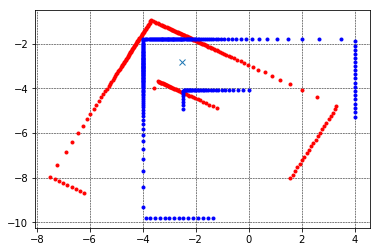

In [11]:
coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[1])
translation = np.vstack(trajectory_OBJ.trajectory[1] - trajectory_OBJ.trajectory[0])

test = ICP.transformation_2D([theta,tx,ty],coords_xy)

plt.figure()
plt.plot(trajectory_OBJ.trajectory[1,0],trajectory_OBJ.trajectory[1,1],'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

plt.plot(trajectory_OBJ.trajectory[0,0] + test[:,0],trajectory_OBJ.trajectory[0,0] + test[:,1],'r.')

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(trajectory_OBJ.trajectory[0,0] + coords_xy[:,0],trajectory_OBJ.trajectory[0,0] + coords_xy[:,1],'b.')

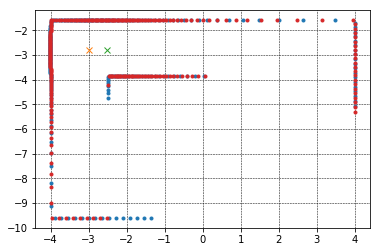

In [12]:
plt.figure()
coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(trajectory_OBJ.trajectory[0,0] + coords_xy[:,0],trajectory_OBJ.trajectory[0,1] + coords_xy[:,1],'.')
plt.plot(trajectory_OBJ.trajectory[0,0],trajectory_OBJ.trajectory[0,1],'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[1])
plt.plot(trajectory_OBJ.trajectory[1,0],trajectory_OBJ.trajectory[1,1],'x')
plt.plot(trajectory_OBJ.trajectory[1,0] + coords_xy[:,0],trajectory_OBJ.trajectory[1,1] + coords_xy[:,1],'.')

In [13]:
def transformation_parameters(path):
    transformation_parameters_between_pose = np.zeros(3)
    for i in range(np.linspace(1,path.shape[0] - 1,dtype='int')):
        x,y = path[i]
        transformation_parameters_between_pose = np.append(transformation_parameters_between_pose,x,y,theta)
    return

In [14]:
print()

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

# Testing

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

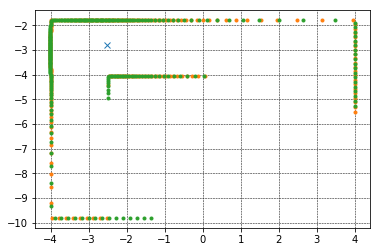

In [15]:
coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[1])
#translation = np.vstack((0,trajectory_OBJ.trajectory[1] - trajectory_OBJ.trajectory[0]))
transformation = np.array([[0],[0.48333],[0]])
test = ICP.transformation_2D(transformation,coords_xy)

plt.figure()
plt.plot(trajectory_OBJ.trajectory[1,0],trajectory_OBJ.trajectory[1,1],'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

plt.plot(trajectory_OBJ.trajectory[0,0] + test[:,0],trajectory_OBJ.trajectory[0,0] + test[:,1],'.')

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(trajectory_OBJ.trajectory[0,0] + coords_xy[:,0],trajectory_OBJ.trajectory[0,0] + coords_xy[:,1],'.')

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

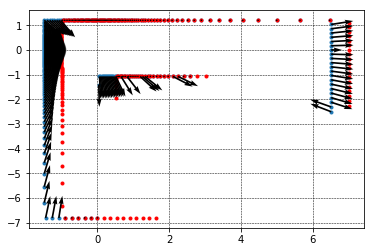

In [17]:
coords_xy1 = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[1])
coords_xy0 = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])

normals_read_to_ref = filters.read_reference_normal_vectors(coords_xy1,coords_xy0)

start,end,interval = 0,240,240
steps = np.linspace(start,end,interval,endpoint=False,dtype='int')

plt.figure()

plt.plot(coords_xy1[steps,0],coords_xy1[steps,1],'.')
plt.grid(color='k', linestyle='--', linewidth=0.5)

for i in steps:
    visualizer.plot_custom_axes(normals_read_to_ref[i],coords_xy1[i])
    
plt.plot(coords_xy0[steps,0],coords_xy0[steps,1],'r.')

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

ICP matching process with adjustable number of matches

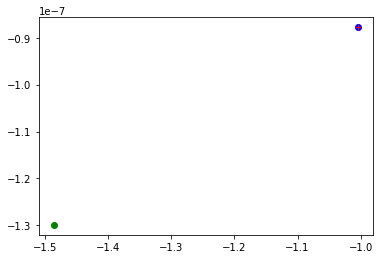

In [18]:
reference = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
read = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[1])

matched, ditances, correspondence_points = ICP.matching(reference, read,1)

plt.figure()
plt.plot(reference[0,0],reference[0,1],'bo')
plt.plot(read[0,0],read[0,1],'go')
plt.plot(matched[:,0,0],matched[:,1,0],'r+')

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Angle minimization between the unit vector from read to reference and the notmal vector at the reference

In [19]:
coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])

normal_vectors,axes, distances = filters.surface_normals(coords_xy,neighbors)
observation_directions = filters.sensor_to_observation_vectors_cartesian(coords_xy)

angles = np.rad2deg(ICP.observation_normal_angle_minimization(normal_vectors,observation_directions))

NameError: name 'neighbors' is not defined

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Data filters, fized sample step size

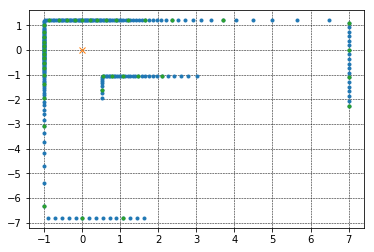

In [20]:
plt.figure()

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

test = filters.subsample(coords_xy,6)
plt.plot(test[:,0],test[:,1],'.')

data filters, randomly sampled points with probability of retained points

0.5375


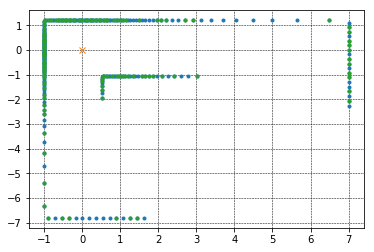

In [21]:
plt.figure()

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

test = filters.random_sample_uniform(coords_xy,0.5)
plt.plot(test[:,0],test[:,1],'.')

print(test.shape[0]/coords_xy.shape[0])

Data filters, fixed bounded box filter rejecting every thing outs side the box

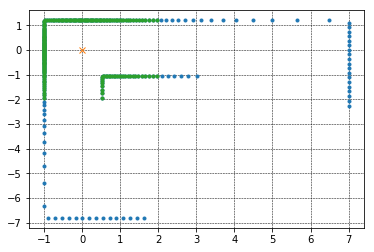

In [22]:
plt.figure()

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

test = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])

test = filters.bounded_box(test,[-2,2],[-2,2])
plt.plot(test[:,0],test[:,1],'.')

Data filters,orientate the normal vectors to a point 

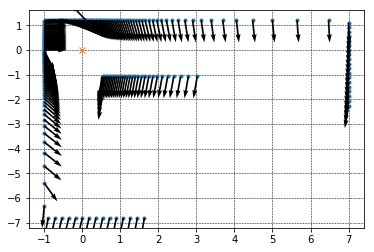

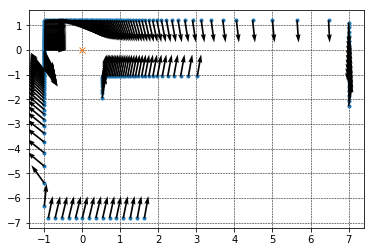

In [23]:
start,end,interval = 0,240,240
neighbors = 10
coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
steps = np.linspace(start,end,interval,endpoint=False,dtype='int')

#plt.figure()

#plt.plot(coords_xy[steps,0],coords_xy[steps,1],'.')
#plt.plot(0,0,'x')
#plt.grid(color='k', linestyle='--', linewidth=0.5)

normal_vectors,axes, distances = filters.surface_normals(coords_xy,neighbors)
observation_directions = filters.sensor_to_observation_vectors_cartesian(coords_xy)

#for i in steps:
#    observation_direction_for_point = observation_directions[i]
#    visualizer.plot_custom_axes(observation_direction_for_point,coords_xy[i])

plt.figure()

plt.plot(coords_xy[steps,0],coords_xy[steps,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

for i in steps:
    visualizer.plot_custom_axes(normal_vectors[i],coords_xy[i])
    
plt.figure()

#plt.plot(coords_xy[steps,0],coords_xy[steps,1],'.')
#plt.plot(0,0,'x')
#plt.grid(color='k', linestyle='--', linewidth=0.5)    

#for i in steps:
#    axis_for_point = axes[i]
#    visualizer.plot_custom_axes(axis_for_point,coords_xy[i])
    
normal_vectors = filters.orientate_normals(normal_vectors,observation_directions)

plt.plot(coords_xy[steps,0],coords_xy[steps,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

for i in steps:
    visualizer.plot_custom_axes(normal_vectors[i],coords_xy[i])

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Testing the co-ordinate transforms

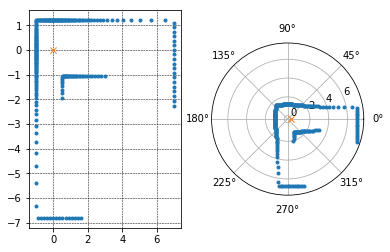

In [24]:
plt.figure()

plt.subplot(1, 2, 1)
coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

plt.subplot(1, 2, 2,projection='polar')
coords_polar = cord_trans.cartesian_to_ploar_2D(coords_xy)
plt.polar(coords_polar[:,0],coords_polar[:,1],'.')
plt.polar(0.,0.,'x')

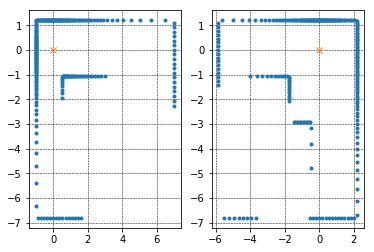

In [25]:
plt.figure()

plt.subplot(1, 2, 1)
coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

plt.subplot(1, 2, 2)
coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[10])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

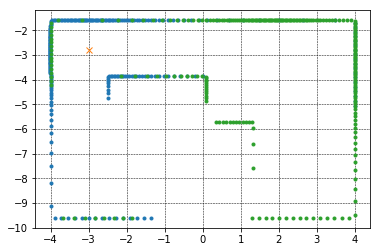

In [26]:
plt.figure()

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(trajectory_OBJ.trajectory[0,0] + coords_xy[:,0],trajectory_OBJ.trajectory[0,1] + coords_xy[:,1],'.')
plt.plot(trajectory_OBJ.trajectory[0,0],trajectory_OBJ.trajectory[0,1],'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[10])
plt.plot(trajectory_OBJ.trajectory[10,0] + coords_xy[:,0],trajectory_OBJ.trajectory[10,1] + coords_xy[:,1],'.')

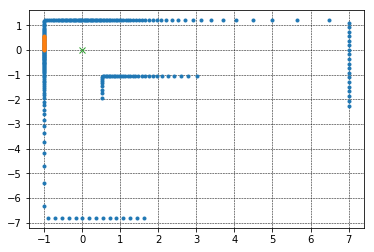

In [27]:
visualizer.plot_scan_surfaces(cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0]),cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])[0:21])

(2, 2)
(2, 2)


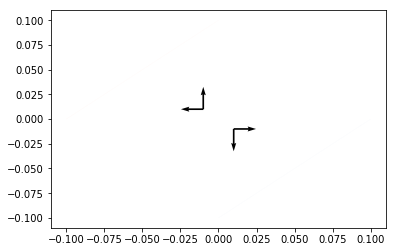

In [28]:
axes = np.array([[1.,0.],[0.,-1.]])
print(axes.shape)
visualizer.plot_custom_axes(axes,[0.01,-0.01])
axes = np.array([[-1.,0.],[0.,1.]])
print(axes.shape)
visualizer.plot_custom_axes(axes,[-0.01,0.01])

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx